<a href="https://colab.research.google.com/github/sfansaria/Machine-Learning/blob/main/Bayesian_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install pyro-ppl

Iteration 100/1000 - Loss: 772.1830065250397
Iteration 200/1000 - Loss: 216.9307581782341
Iteration 300/1000 - Loss: 251.2169755101204
Iteration 400/1000 - Loss: 268.46377140283585
Iteration 500/1000 - Loss: 224.59383153915405
Iteration 600/1000 - Loss: 238.92583549022675
Iteration 700/1000 - Loss: 297.1948266029358
Iteration 800/1000 - Loss: 2432.641790151596
Iteration 900/1000 - Loss: 252.7075436115265
Iteration 1000/1000 - Loss: 457.0952706336975
Estimated Slope: 1.5630635023117065
Estimated Intercept: 1.5442348718643188
Estimated Sigma: 3.8586456775665283


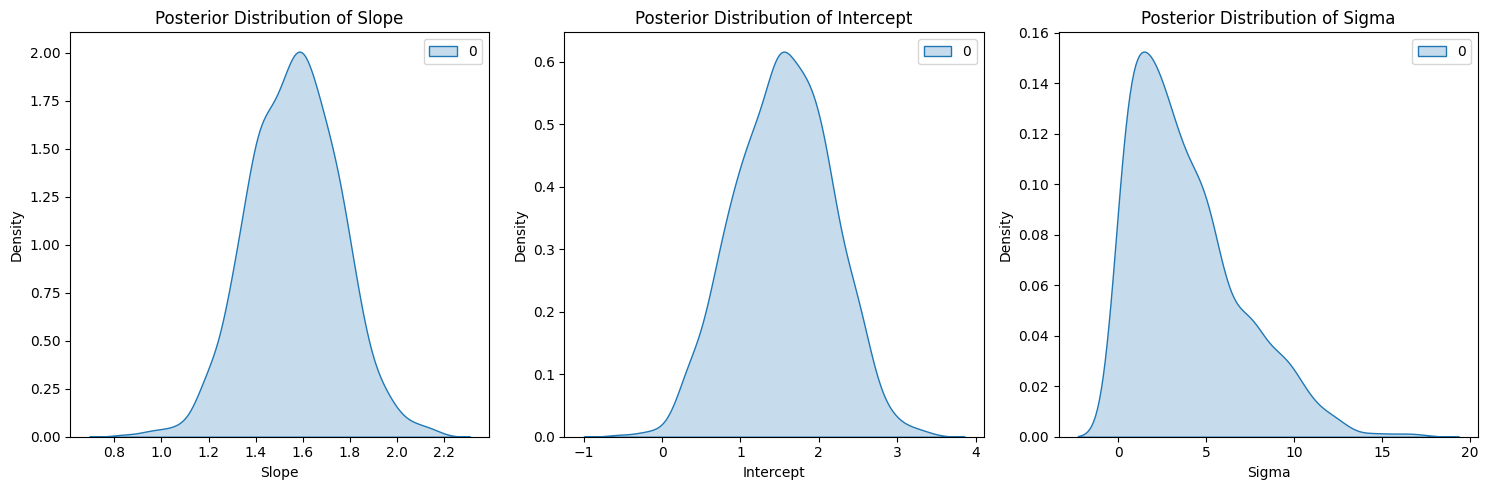

In [14]:
import warnings
#Import the libraries
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns

#Generate data sample
torch.manual_seed(0)
X = torch.linspace(0, 10, 100)
true_slope = 2
true_intercept = 1
Y = true_intercept + true_slope*X + torch.randn(100)

#Define the Bayesian regression model
def model(X, Y):
    #Priors for the parameters
    slope = pyro.sample("slope", dist.Normal(0, 10))
    intercept = pyro.sample("intercept", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.HalfNormal(1))

    #Expected value of the outcome
    mu = intercept + slope*X

    #LikeLihood (sampling  distribution) of the observations
    with pyro.plate("data", len(X)):
       pyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

#Run Bayesian inference using SVI(Stochastic Variational Inference)

def guide(X, Y):
  #Approximate posterior distributions for the parameters
  slope_loc = pyro.param("slope_loc", torch.tensor(0.0))
  slope_scale = pyro.param("slope_scale", torch.tensor(1.0),constraint=dist.constraints.positive)
  intercept_loc = pyro.param("intercept_loc", torch.tensor(0.0))
  intercept_scale = pyro.param("intercept_scale", torch.tensor(1.0),constraint=dist.constraints.positive)
  sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0),constraint=dist.constraints.positive)
  #sample from the approximate posterior distributions
  slope = pyro.sample("slope", dist.Normal(slope_loc,slope_scale))
  intercept = pyro.sample("intercept", dist.Normal(intercept_loc,intercept_scale))
  sigma = pyro.sample("sigma", dist.HalfNormal(sigma_loc))

#Initialize the SVI and optimizer

optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim,loss=Trace_ELBO())

#Run the inference loop
num_iterations = 1000
for i in range(num_iterations):
    loss = svi.step(X, Y)
    if (i+1)%100 == 0:
      print(f"Iteration {i+1}/{num_iterations} - Loss: {loss}")

#Obtain posterior samples using Predictive
predictive = Predictive(model, guide=guide, num_samples=1000)
posterior = predictive(X, Y)

#Extract the parameter samples
slope_samples = posterior["slope"]
intercept_samples = posterior["intercept"]
sigma_samples = posterior["sigma"]

#Compute the posterior means
slope_mean = slope_samples.mean()
intercept_mean = intercept_samples.mean()
sigma_mean = sigma_samples.mean()

#PRint the estimated parameters
print("Estimated Slope:", slope_mean.item())
print("Estimated Intercept:", intercept_mean.item())
print("Estimated Sigma:", sigma_mean.item())

#Create subplots

fig, axs = plt.subplots(1,3,figsize=(15, 5))

#PLot the posterior distribution of the slope
sns.kdeplot(slope_samples, fill=True, ax=axs[0])
axs[0].set_title("Posterior Distribution of Slope")
axs[0].set_xlabel("Slope")
axs[0].set_ylabel("Density")

#PLot the posterior distribution of the intercept

sns.kdeplot(intercept_samples, fill=True, ax=axs[1])
axs[1].set_title("Posterior Distribution of Intercept")
axs[1].set_xlabel("Intercept")
axs[1].set_ylabel("Density")

#PLot the posterior distribution of the sigma
sns.kdeplot(sigma_samples, fill=True, ax=axs[2])
axs[2].set_title("Posterior Distribution of Sigma")
axs[2].set_xlabel("Sigma")
axs[2].set_ylabel("Density")

#Adjust the layout
plt.tight_layout()

#SHow the plot
plt.show()

